In [100]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from ydata_profiling import ProfileReport 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10  BMI                              2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

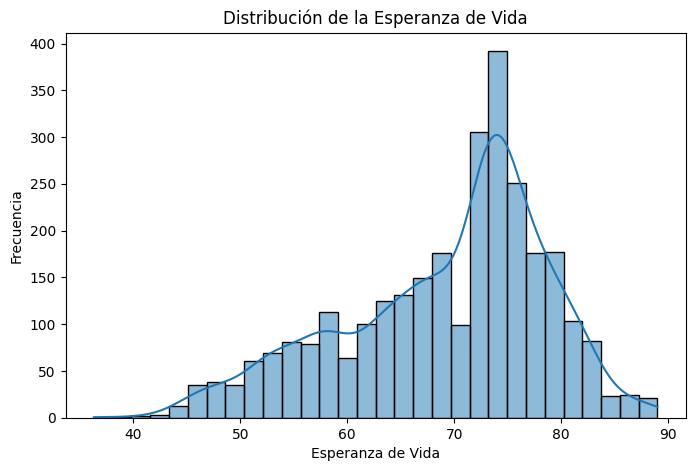

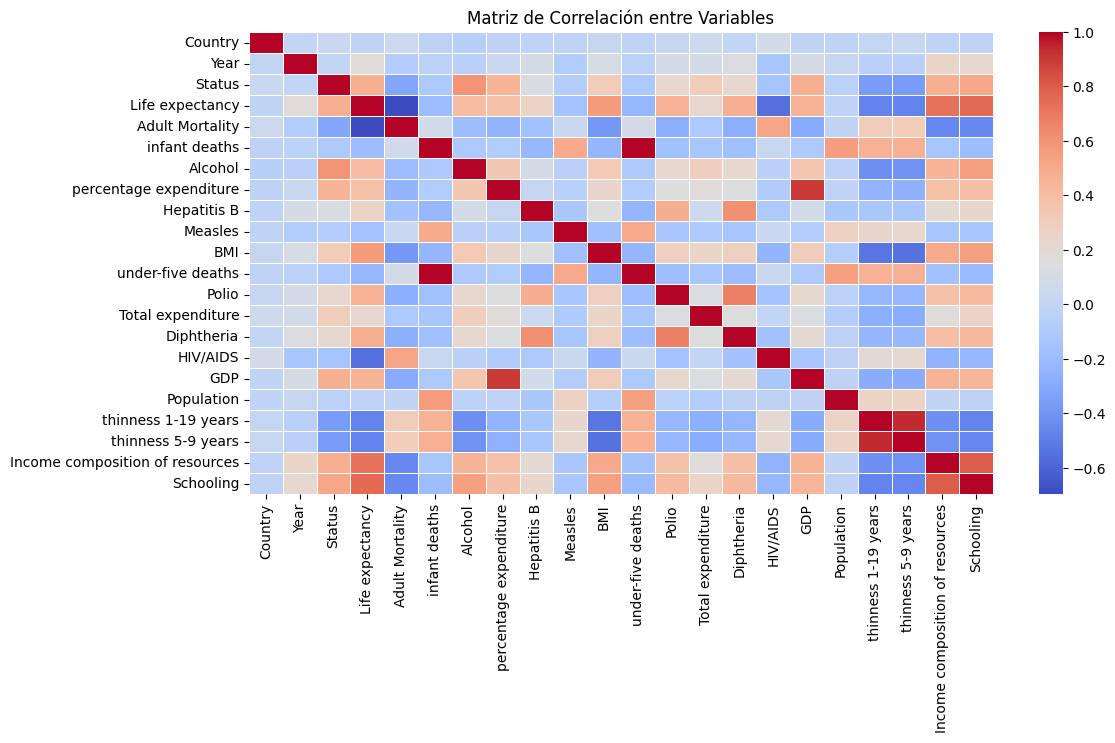

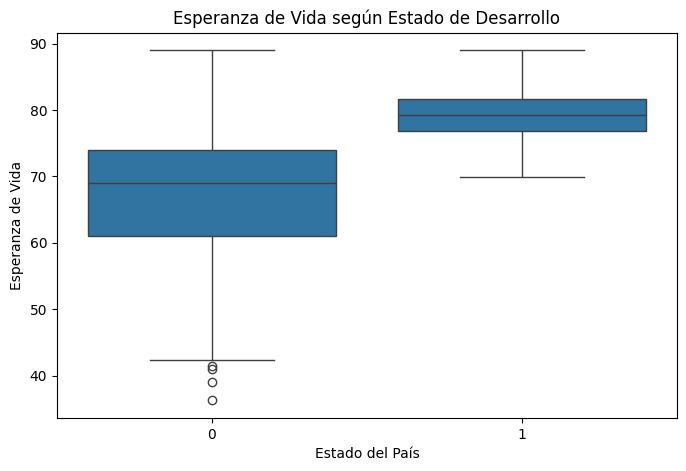

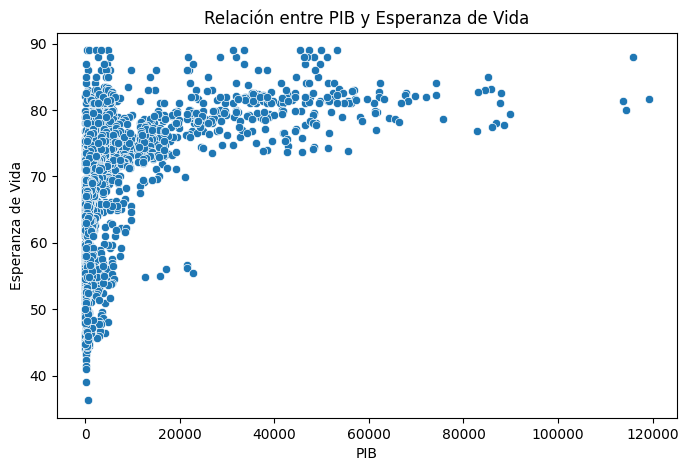

In [101]:
# -----------------------------------------------
# PUNTO 1: Cargar el dataset
# -----------------------------------------------

# 1. Cargarmos el dataset
df = pd.read_csv("Life Expectancy Data.csv")

# -----------------------------------------------
# PUNTO 2: Explorar el dataset
# -----------------------------------------------

# Información general del dataset
df.info()

# Resumen estadístico
print(df["Life expectancy"].describe())

# Verificar valores nulos
missing_values = df.isnull().sum()
print("Valores nulos por columna:\n", missing_values[missing_values > 0])

# Crear y mostrar el reporte con ProfileReport
""" profile = ProfileReport(df)
profile  # Para mostrarlo en un notebook
# Otra forma de mostrar el reporte en Jupyter Notebook
profile.to_notebook_iframe()

# O guardarlo en un archivo HTML
profile.to_file("reporte_datos.html") """

# -----------------------------------------------
# PUNTO 3: Preprocesamiento de datos para poder explorarlos
# -----------------------------------------------

# Mapear los valores de Status a 0 y 1
df["Status"] = df["Status"].map({"Developing": 0, "Developed": 1})

# Inicializar el codificador
label_encoder = LabelEncoder()

# Aplicar Label Encoding a la columna de países
df["Country"] = label_encoder.fit_transform(df["Country"])

# -----------------------------------------------
# PUNTO 4: Análisis EDA (Exploratory Data Analysis)
# -----------------------------------------------

# Distribución de la variable objetivo (Esperanza de vida)
plt.figure(figsize=(8, 5))
sns.histplot(df["Life expectancy"].dropna(), bins=30, kde=True)
plt.title("Distribución de la Esperanza de Vida")
plt.xlabel("Esperanza de Vida")
plt.ylabel("Frecuencia")
plt.show()

# Matriz de correlación
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlación entre Variables")
plt.show()

# Boxplot de esperanza de vida por país desarrollado vs. en desarrollo
plt.figure(figsize=(8, 5))
sns.boxplot(x="Status", y="Life expectancy", data=df)
plt.title("Esperanza de Vida según Estado de Desarrollo")
plt.xlabel("Estado del País")
plt.ylabel("Esperanza de Vida")
plt.show()

# Scatter plot PIB vs. Esperanza de Vida
plt.figure(figsize=(8, 5))
sns.scatterplot(x="GDP", y="Life expectancy", data=df)
plt.title("Relación entre PIB y Esperanza de Vida")
plt.xlabel("PIB")
plt.ylabel("Esperanza de Vida")
plt.show()

### Limpieza y preprocesamiento

In [102]:
# Limpieza de datos nulos
# df = df.dropna()
# 1. Manejo de valores nulos: Rellenamos con la mediana de cada columna numérica
df.fillna(df.median(numeric_only=True), inplace=True)

# Elejimos las variables predictoras y a predecir
X = df.drop(columns=["Life expectancy"])
y = df["Life expectancy"]

# Escalamos las variables independientes con StandarScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Tamaño de X_scaled: {X.shape}, Tamaño de y: {y.shape}") # Asegurar que X_scaled y y tienen el mismo número de filas


Tamaño de X_scaled: (2938, 21), Tamaño de y: (2938,)


### Primer entrenamiento

Las dimensiones de las variables objetivo y las de la variable a predecir tienen el mismo tamaño tras la normalización.

In [103]:
# Calculamos las variables de correlación con la variable objetivo
df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
df_scaled["Life expectancy"] = y
correlaciones = df_scaled.corr()["Life expectancy"].sort_values(ascending=False)

# Mostramos la correlación de cada variable con la variable objetivo
print("Correlaciones con la variable objetivo: ")
print(correlaciones)

Correlaciones con la variable objetivo: 
Life expectancy                    1.000000
Schooling                          0.713054
Income composition of resources    0.688662
BMI                                0.556901
Status                             0.481415
Diphtheria                         0.472211
Polio                              0.458399
GDP                                0.430461
Alcohol                            0.388918
percentage expenditure             0.381418
Total expenditure                  0.208844
Year                               0.170819
Hepatitis B                        0.170219
Country                           -0.016402
Population                        -0.029014
Measles                           -0.157767
infant deaths                     -0.196769
under-five deaths                 -0.222738
thinness 5-9 years                -0.462473
thinness 1-19 years               -0.468002
HIV/AIDS                          -0.556703
Adult Mortality                   -

Todas las variables que presentan una correlación por debajo de 0 frente a la variable objetivo deben ser eliminadas ya que no aportan al modelo.

In [104]:
# Calcular el VIF para detectar colinealidad entre variables
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

# Mostrar los resultados
print("VIF de cada variable:")
print(vif_data)

VIF de cada variable:
                           Variable         VIF
0                           Country    1.037915
1                              Year    1.156925
2                            Status    1.901819
3                   Adult Mortality    1.744939
4                     infant deaths  178.069916
5                           Alcohol    1.916418
6            percentage expenditure    5.817880
7                       Hepatitis B    1.313679
8                           Measles    1.382455
9                               BMI    1.725350
10                under-five deaths  176.970795
11                            Polio    1.942524
12                Total expenditure    1.223460
13                       Diphtheria    2.165308
14                         HIV/AIDS    1.451241
15                              GDP    6.036734
16                       Population    1.491120
17              thinness 1-19 years    8.792670
18               thinness 5-9 years    8.900249
19  Income composi

Escala de valores del VIF:
- VIF < 5 → No hay problema de colinealidad.
- VIF entre 5 y 10 → Hay colinealidad moderada, revisar.
- VIF > 10 → Fuerte colinealidad, se recomienda eliminar la variable.

Variables afectadas:
- ``infant deaths`` y ``under-five deaths``: Presentan colinealidades parecidas ya que representan datos parecidos. Eliminar una de ellas
- Pasa lo mismo con ``thinness 1-19 years`` y ``thinness 5-9 years`` , ``GDP`` y ``percentage expenditure``. Ya que estos pares de variables reprentan características muy similares nos quedamos con una de ellas.

In [105]:
# Dividir el dataset en entrenamiento (80%) y prueba (20%) con train_test_split()
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Entrenar el modelo de Regresión Lineal con LinearRegression()
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Obtener e interpretar los coeficientes y el intercepto del modelo
coeficientes = pd.Series(modelo.coef_, index=X.columns)

print("Intercepto:", modelo.intercept_)
print("Coeficientes del modelo:")
print(coeficientes.sort_values(ascending=False))

Intercepto: 69.27356115044446
Coeficientes del modelo:
infant deaths                      11.572355
Schooling                           2.085445
Income composition of resources     1.258154
Diphtheria                          0.982063
BMI                                 0.807624
Polio                               0.640143
Status                              0.614966
GDP                                 0.514006
Alcohol                             0.241839
Country                             0.174976
percentage expenditure              0.108796
Total expenditure                   0.077768
thinness 5-9 years                  0.055114
Year                                0.000817
Population                         -0.061860
Measles                            -0.261505
thinness 1-19 years                -0.418085
Hepatitis B                        -0.453906
HIV/AIDS                           -2.351152
Adult Mortality                    -2.576142
under-five deaths                 -11.709283


Eliminar todas las variables que poseen un coeficiente negativo.

In [106]:
# Realizar predicciones con modelo.predict(X_test)
y_pred = modelo.predict(X_test)

# Evaluar el modelo 
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Mostrar resultados
print(f"MAE (Error Absoluto Medio): {mae:.4f}")
print(f"MSE (Error Cuadrático Medio): {mse:.4f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.4f}")
print(f"R² (Coeficiente de Determinación): {r2:.4f}")

MAE (Error Absoluto Medio): 2.8458
MSE (Error Cuadrático Medio): 15.1402
RMSE (Raíz del Error Cuadrático Medio): 3.8910
R² (Coeficiente de Determinación): 0.8253


- MAE = 2.8458 → En promedio, el modelo se equivoca en 2.85 años a la esperanza de vida calculada.
- RMSE = 3.8910 → Penaliza más los errores grandes.
- R² = 0.8253 → El modelo solo explica el 82.5% de la variabilidad en los años de la esperanza de vida.

### Segundo entrenamiento
Eliminamos las siguientes variables basándonos en el análisis anterior: 
- ``Country``                           
- ``Population``                        
- ``Measles``                           
- ``infant deaths``                     
- ``under-five deaths``                 
- ``thinness 5-9 years``               
- ``thinness  1-19 years``             
- ``HIV/AIDS``                         
- ``Adult Mortality``   
- ``percentage expenditure``   
- ``Hepatitis B``
        

In [107]:
# Elejimos las variables predictoras y a predecir
X = df.drop(columns=["Life expectancy", "Country", "Population", "Measles", "infant deaths", "under-five deaths", "thinness 5-9 years", "thinness 1-19 years", "HIV/AIDS", "Adult Mortality", "percentage expenditure", "Hepatitis B"])
y = df["Life expectancy"]

# Escalamos las variables independientes con StandarScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Tamaño de X_scaled: {X.shape}, Tamaño de y: {y.shape}") # Asegurar que X_scaled y y tienen el mismo número de filas

# Calculamos las variables de correlación con la variable objetivo
df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
df_scaled["Life expectancy"] = y
correlaciones = df_scaled.corr()["Life expectancy"].sort_values(ascending=False)

# Mostramos la correlación de cada variable con la variable objetivo
print("Correlaciones con la variable objetivo: ")
print(correlaciones)

# Calcular el VIF para detectar colinealidad entre variables
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

# Mostrar los resultados
print("VIF de cada variable:")
print(vif_data)

# Dividir el dataset en entrenamiento (80%) y prueba (20%) con train_test_split()
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Entrenar el modelo de Regresión Lineal con LinearRegression()
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Obtener e interpretar los coeficientes y el intercepto del modelo
coeficientes = pd.Series(modelo.coef_, index=X.columns)

print("Intercepto:", modelo.intercept_)
print("Coeficientes del modelo:")
print(coeficientes.sort_values(ascending=False))

# Realizar predicciones con modelo.predict(X_test)
y_pred = modelo.predict(X_test)

# Evaluar el modelo 
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Mostrar resultados
print(f"MAE (Error Absoluto Medio): {mae:.4f}")
print(f"MSE (Error Cuadrático Medio): {mse:.4f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.4f}")
print(f"R² (Coeficiente de Determinación): {r2:.4f}")

Tamaño de X_scaled: (2938, 10), Tamaño de y: (2938,)
Correlaciones con la variable objetivo: 
Life expectancy                    1.000000
Schooling                          0.713054
Income composition of resources    0.688662
BMI                                0.556901
Status                             0.481415
Diphtheria                         0.472211
Polio                              0.458399
GDP                                0.430461
Alcohol                            0.388918
Total expenditure                  0.208844
Year                               0.170819
Name: Life expectancy, dtype: float64
VIF de cada variable:
                          Variable       VIF
0                             Year  1.125511
1                           Status  1.834488
2                          Alcohol  1.748075
3                              BMI  1.412901
4                            Polio  1.900467
5                Total expenditure  1.165095
6                       Diphtheria  1.918430
7 

### Conclusión

Al haber eliminado las variables que presentan correlaciones bajas, colinealidad altas y ceoficientes altos obtenemos un coeficiente de determinación peor que el anterior modelo. <br>
Los registros actuales no son suficientes para aportar suficiente explicabilidad necesitariamos mas registros.